# Wavelength Placement

The goal here is to experiment with how our WCS is remapping wavelength to detector position and to show where different lines show up based on the position of the source on the solar disk.

In [114]:
import pathlib
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support, ImageNormalize, LogStretch, AsymmetricPercentileInterval
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.coordinates import SkyCoord
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
import fiasco
import aiapy.response
from sunpy.coordinates import get_earth, Helioprojective

from fiasco.io import Parser
from synthesizAR.instruments import InstrumentDEM

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response, ThinFilmFilter
from overlappy.wcs import overlappogram_fits_wcs, pcij_matrix

%matplotlib inline

Compute the spectra in detector units as a function of wavelength

In [115]:
line_ids = [
    ('Fe XVIII',14.21*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 15.01*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 16.78*u.AA),
    ('Fe XVII', 17.05*u.AA),
    ('O VII', 21.60*u.angstrom),  # also targeted by MaGIXS
    ('O VII', 21.81*u.angstrom),
    ('O VII', 22.10*u.AA),
    ('O VIII', 18.97*u.angstrom),  # also targeted by MaGIXS
    ('Fe XXV', 1.86*u.AA),
    ('Ca XIX', 3.21*u.AA),
    ('Si XIII', 6.74*u.AA),
    ('Mg XI', 9.32*u.AA),
    ('Fe XVII', 11.25*u.AA),
    ('Fe XX', 12.83*u.AA),
    ('Ne IX', 13.45*u.AA),
    ('Fe XIX', 13.53*u.AA),
    ('C VI', 33.73*u.AA),
    ('C V', 40.27*u.AA),
    ('Si XII', 44.16*u.AA),
    ('Si XI', 49.18*u.AA),
]

In [116]:
def add_line_ids_to_axis(ax, line_ids, rotation=90, line_unit=None):
    for ion,line in line_ids:
        ax.axvline(x=line.to_value(line_unit), ls=':', color='k',)
    ax2 = ax.secondary_xaxis('top') 
    ax2.set_xticks(u.Quantity([l for _,l in line_ids]).to_value(line_unit),
                   labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
                   rotation=rotation,
                   horizontalalignment='center',
                   #verticalalignment='center'
                  )

In [117]:
def dem_table_to_ndcube(dem_table):
    temperature = dem_table['temperature_bin_center']
    em = dem_table['dem']*np.gradient(temperature, edge_order=2)
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(em, wcs=tab_coord.wcs, meta=dem_table.meta)

In [118]:
def degrade_spectra(spec, resolution):
    std = resolution / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [119]:
dem_flare = dem_table_to_ndcube(Parser('flare.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse())

In [120]:
spec_tables = get_spectral_tables()

In [224]:
intensity_flare = InstrumentDEM.calculate_intensity(dem_flare, spec_tables['sun_coronal_1992_feldman_ext_all'], {})

Set up instrument response

In [162]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')
chan_o1 = SpectrogramChannel(1, al_filter)
chan_o3 = SpectrogramChannel(3, al_filter)
chan_om1 = SpectrogramChannel(-1, al_filter)
chan_om3 = SpectrogramChannel(-3, al_filter)

In [122]:
flux_o1 = convolve_with_response(intensity_flare, chan_o1, electrons=False, include_gain=False)
flux_o3 = convolve_with_response(intensity_flare, chan_o3, electrons=False, include_gain=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


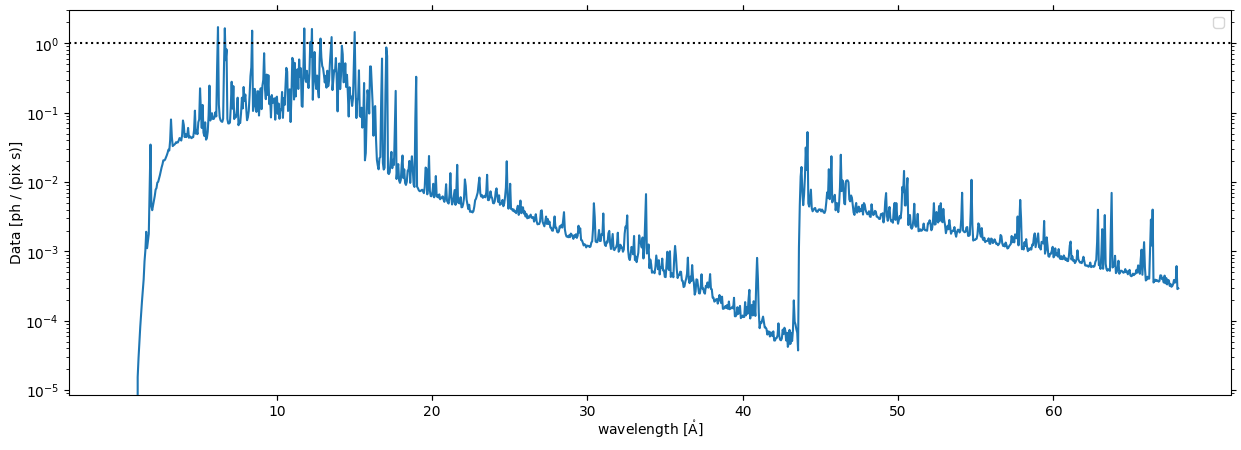

In [123]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_o1)
flux_o1.plot(axes=ax)
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

Now, we want to know at which detector pixel we expect each of these points to show up

In [254]:
earth_observer = get_earth(time='2020-01-01 12:00:00')

In [255]:
roll_angle = -90 * u.deg
dispersion_angle = 0*u.deg

In [256]:
wcs_o1 = overlappogram_fits_wcs(
    chan_o1.detector_shape,
    chan_o1.wavelength,
    (chan_o1.resolution[0], chan_o1.resolution[1], chan_o1.spectral_resolution),
    reference_pixel=chan_o1.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_o1.spectral_order,),
    observer=earth_observer,
)
wcs_o3 = overlappogram_fits_wcs(
    chan_o3.detector_shape,
    chan_o3.wavelength,
    (chan_o3.resolution[0], chan_o3.resolution[1], chan_o3.spectral_resolution),
    reference_pixel=chan_o3.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_o3.spectral_order,),
    observer=earth_observer,
)
wcs_om1 = overlappogram_fits_wcs(
    chan_om1.detector_shape,
    chan_om1.wavelength,
    (chan_om1.resolution[0], chan_om1.resolution[1], chan_om1.spectral_resolution),
    reference_pixel=chan_om1.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_om1.spectral_order,),
    observer=earth_observer,
)
wcs_om3 = overlappogram_fits_wcs(
    chan_om3.detector_shape,
    chan_om3.wavelength,
    (chan_om3.resolution[0], chan_om3.resolution[1], chan_om3.spectral_resolution),
    reference_pixel=chan_om3.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_om3.spectral_order,),
    observer=earth_observer,
)

In [257]:
flare_loc = SkyCoord(Tx=-900*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

In [258]:
pix_x_o1, _, _ = wcs_o1.world_to_pixel(flare_loc, chan_o1.wavelength)
pix_x_o3, _, _ = wcs_o3.world_to_pixel(flare_loc, chan_o3.wavelength)

In [259]:
flux_total = ndcube.NDCube(flux_o1.data+np.interp(pix_x_o1, pix_x_o3, flux_o3.data),
                           wcs=flux_o1.wcs, unit=flux_o1.unit, )

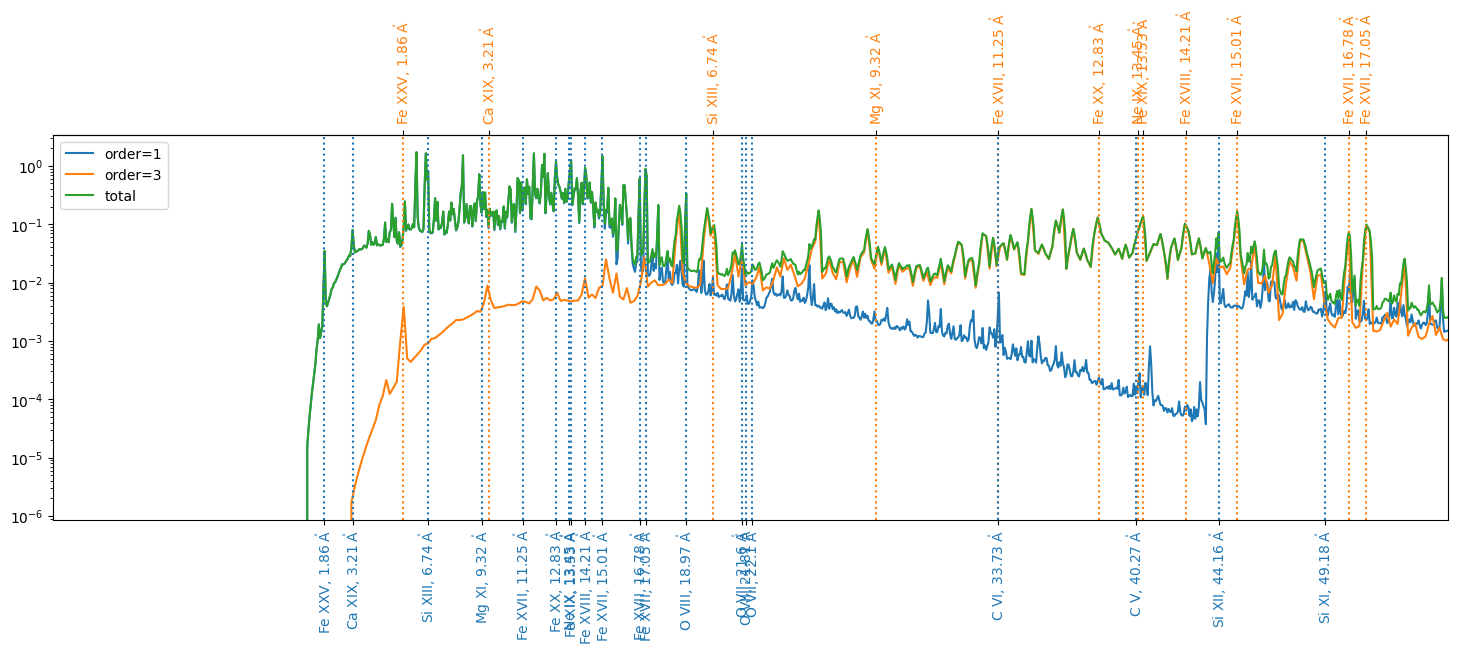

In [260]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot()
line_o1, = ax.plot(pix_x_o1, flux_o1.data, label='order=1')
line_o3, = ax.plot(pix_x_o3, flux_o3.data, label='order=3')
ax.plot(pix_x_o1, flux_total.data, label='total')
#ax.plot(pix_x_o1, label='total')
ax.set_yscale('log')
# Add line labels to axis 
for ion,line in line_ids:
    x_pos,_,_ = wcs_o1.world_to_pixel(flare_loc, line)
    ax.axvline(x=x_pos, ls=':', color=line_o1.get_color(),)
    x_pos,_,_ = wcs_o3.world_to_pixel(flare_loc, line)
    ax.axvline(x=x_pos, ls=':', color=line_o3.get_color(),)
ax.set_xticks(wcs_o1.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0],
               labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
               rotation=90,
               horizontalalignment='center',
               #verticalalignment='center',
               color=line_o1.get_color(),
              );
ax2 = ax.secondary_xaxis('top') 
ax2.set_xticks(wcs_o3.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0],
               labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
               rotation=90,
               horizontalalignment='center',
               #verticalalignment='center',
               color=line_o3.get_color(),
              );
ax.set_xlim(800,2000)
#ax.set_xlim(wcs_o1.world_to_pixel(flare_loc, [16,22]*u.angstrom)[0])
ax.legend(loc=2,)

In [251]:
blur = .5*u.angstrom
flux_o1_blur = degrade_spectra(flux_o1, blur)
flux_o3_blur = degrade_spectra(flux_o3, blur/3)
flux_total_blur = degrade_spectra(flux_total, blur)

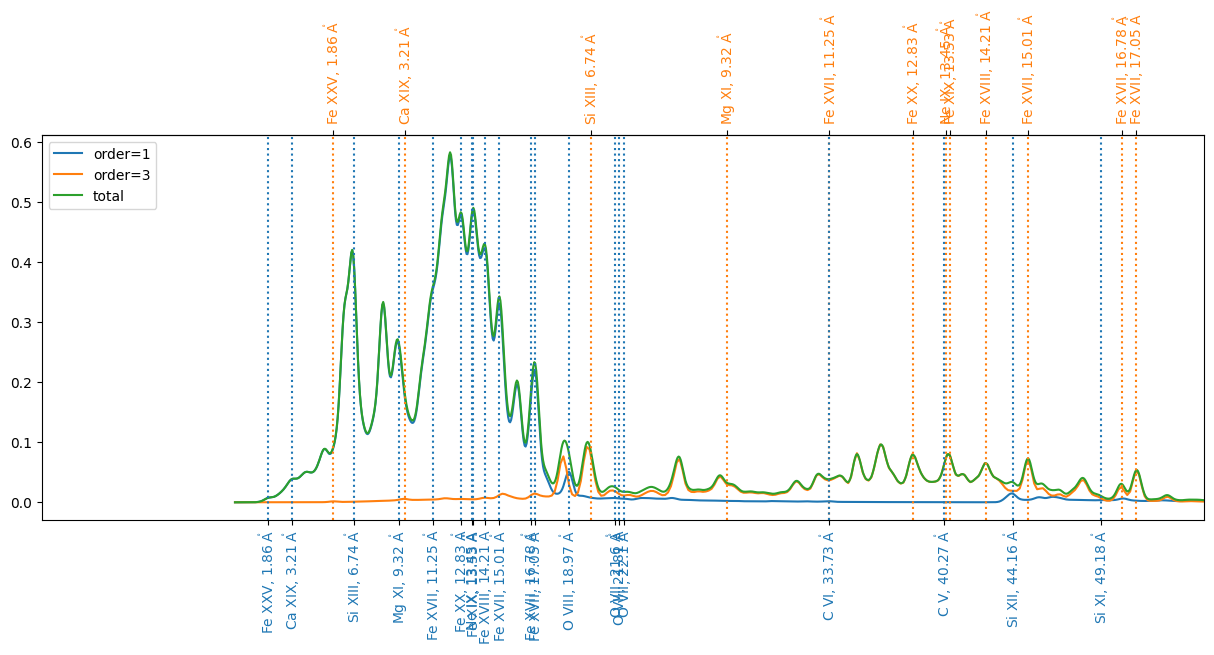

In [253]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
line_o1, = ax.plot(pix_x_o1, flux_o1_blur.data, label='order=1')
line_o3, = ax.plot(pix_x_o3, flux_o3_blur.data, label='order=3')
ax.plot(pix_x_o1, flux_total_blur.data, label='total')
#ax.plot(pix_x_o1, label='total')
#ax.set_yscale('log')
# Add line labels to axis 
for ion,line in line_ids:
    x_pos,_,_ = wcs_o1.world_to_pixel(flare_loc, line)
    ax.axvline(x=x_pos, ls=':', color=line_o1.get_color(),)
    x_pos,_,_ = wcs_o3.world_to_pixel(flare_loc, line)
    ax.axvline(x=x_pos, ls=':', color=line_o3.get_color(),)
ax.set_xticks(wcs_o1.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0],
               labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
               rotation=90,
               horizontalalignment='center',
               #verticalalignment='center',
               color=line_o1.get_color(),
              );
ax2 = ax.secondary_xaxis('top') 
ax2.set_xticks(wcs_o3.world_to_pixel(flare_loc, u.Quantity([l for _,l in line_ids]))[0],
               labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
               rotation=90,
               horizontalalignment='center',
               #verticalalignment='center',
               color=line_o3.get_color(),
              );
ax.set_xlim(800,2000)
ax.legend(loc=2,)